# Demo of VAE for anomaly detection of diverse sensor data
Trained on non-fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%matplotlib inline

In [2]:
from IPython.core.debugger import set_trace

In [3]:
from demo import *
device

device(type='cuda', index=0)

In [4]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [5]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 24.669
Epoch: 231


In [6]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 50, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [7]:
X, E, L, D = [param.cpu().detach().numpy() for param in params]
MSE = np.power((X - D), 2).sum() / 2
print(f"MSE of random data = {MSE:.3f}")

MSE of random data = 623.597


In [8]:
X[:, :4, :4]

array([[[0.5640662 , 0.07256254, 0.34665662, 0.7310924 ],
        [0.5191273 , 0.07623857, 0.94880766, 0.5059113 ],
        [0.86389107, 0.5546202 , 0.956635  , 0.4438814 ],
        [0.18362638, 0.7440409 , 0.42304328, 0.08344804]]], dtype=float32)

In [9]:
D[:, :4, :4]

array([[[ 0.17327529,  0.14070164,  0.20175217,  0.35667062],
        [ 0.20141046, -0.05190606, -0.09381868, -0.08726995],
        [ 0.3550945 ,  0.33637995,  0.33439082,  0.46311247],
        [ 0.21425018,  0.3574765 ,  0.45235863,  0.606486  ]]],
      dtype=float32)

Next we need to load the datasets of sensors readings.

In [10]:
data_path = Path(f'data/hydraulic/{desc}')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [11]:
print(len(train_dl), len(val_dl), len(test_dl))

33 9 920


Let's get some random samples from the dataset for examples and generate new versions.

In [12]:
data, targets = get_random_samples(test_dl)

In [13]:
classes = list_target_classes(test_dl)

0 = fail
1 = norm


In [69]:
targets = targets.cpu().numpy()
targets[:10]

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [15]:
y_true = targets == 0
y_true.sum() / y_true.size

0.5347826086956522

In [16]:
print('normals = ', targets.sum())

normals =  428


In [17]:
print('failures = ', len(targets) - targets.sum())

failures =  492


In [18]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [19]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
    loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [20]:
gen_err = -loss_desc['logp']
gen_err[:10]

tensor([ 34.9933,  20.9308, 615.4092,   9.3176,   2.6278,   3.4230,  53.7225,
          9.5514,  15.0133,  38.8410,  51.4053, 618.1707,  38.9390, 647.7456,
        401.0341, 672.7718,   5.0200,  47.4667,  50.1906, 634.3417,  56.4695,
         21.0668, 512.2001,  60.7875, 656.5350,  54.3296,  38.0518,   4.4200,
          5.1153,  53.4521,   1.2322,  48.1506, 636.8378,  39.8869, 624.2942,
         29.0222,  40.1991, 652.9014,  31.4439,   3.0274,  18.0785,  32.4598,
         61.9073,  35.0349,   1.2592,   1.1547, 666.5234, 627.9611, 635.8931,
         12.6667,   2.6461,  30.5508,  46.1653,   3.3291, 656.2947,   2.5136,
          3.0277,  36.7444,  43.6156,   9.3785,  25.7710, 627.9572,  46.1096,
        670.1098, 645.4138,   1.0899,  41.2880,  35.2123, 616.9534,  50.6825,
        619.6513,  58.4830, 640.0995, 629.4969,   2.9749, 657.7352,   2.7522,
        103.9495,  26.9017,  30.9895,  45.2490,   2.0328,  50.9665,   3.7756,
          4.7077,   6.8790,  53.0973,  58.6658,  53.5561, 623.98

[[ 0.05035274  0.05933259  0.03042854  0.00123784 -0.00725427]
 [ 0.00908636 -0.00535209  0.0137138   0.01928899  0.00790696]
 [ 0.1421383   0.13855946  0.15627384  0.09138978  0.10891372]
 [ 0.03278169 -0.0023666   0.00395879  0.01805407  0.02956104]
 [ 0.00339389 -0.00883208  0.00485787  0.02175372 -0.0080207 ]]
MSE = 34.99329376220703


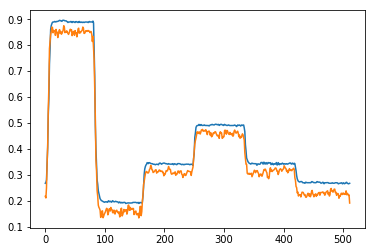

In [21]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

[[ 0.03083675  0.03967848  0.02884953 -0.00761902  0.03307953]
 [ 0.03438169 -0.00853417  0.01677147  0.01971878  0.00865154]
 [ 0.1268175   0.12565169  0.1382047   0.07003909  0.08758098]
 [ 0.03331375  0.01687622  0.0467979   0.08868045  0.12593907]
 [-0.0009737   0.00080231  0.0132406   0.03124271 -0.00191669]]
MSE = 20.9307861328125


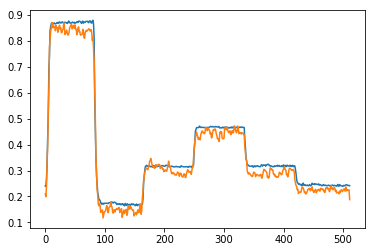

In [22]:
idx = 1
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

In [23]:
err = np.zeros(targets.shape)
for i, target in enumerate(targets):
    err[i] = -loss_desc['logp'][i]
    print(f"Target = {target}, MSE = {err[i]:.3f}")
    if i > 10:
        break

Target = 1, MSE = 34.993
Target = 1, MSE = 20.931
Target = 0, MSE = 615.409
Target = 1, MSE = 9.318
Target = 0, MSE = 2.628
Target = 0, MSE = 3.423
Target = 0, MSE = 53.723
Target = 0, MSE = 9.551
Target = 1, MSE = 15.013
Target = 1, MSE = 38.841
Target = 1, MSE = 51.405
Target = 0, MSE = 618.171


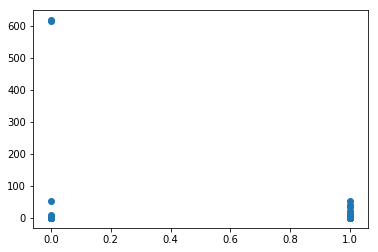

In [24]:
plt.scatter(targets, err)

Show the data plots.

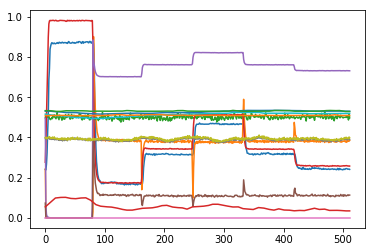

In [25]:
show_plot(sample)

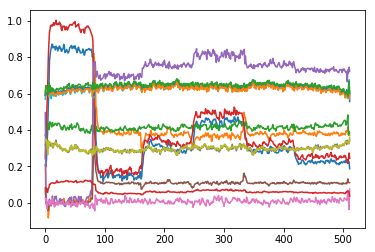

In [26]:
show_plot(gen_sample)

Let's score the success of the recreation and look for outliers.

In [27]:
scores = score(test_dl, model, criterion)

100%|██████████| 920/920 [00:06<00:00, 149.01it/s]


In [28]:
test_means = pd.DataFrame()
for (name, cls), item in scores.items():
    test_means.loc[name, cls] = np.array(item).mean()

print("###################### TEST MEANS #####################")
print(test_means)

###################### TEST MEANS #####################
               fail        norm
loss   9.668144e+06  182.746525
KL     9.667911e+06   39.184857
error  2.328859e+02  143.561667


In [29]:
val_means = pd.DataFrame()
for (name, cls), item in score(val_dl, model, criterion).items():
    val_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(val_means)

100%|██████████| 9/9 [00:01<00:00,  5.86it/s]

###################### VAL MEANS #####################
             norm
loss   184.063031
KL      41.402983
error  142.660047


In [30]:
train_means = pd.DataFrame()
for (name, cls), item in score(train_dl, model, criterion).items():
    train_means.loc[name, cls] = np.array(item).mean()

print("###################### TRAIN MEANS #####################")
print(train_means)

100%|██████████| 33/33 [00:05<00:00,  5.92it/s]

###################### TRAIN MEANS #####################
             norm
loss   179.859625
KL      40.112007
error  139.747618


Let's calculate AUC to judge performance.

In [31]:
scores.keys()

dict_keys([('loss', 'fail'), ('loss', 'norm'), ('KL', 'fail'), ('KL', 'norm'), ('error', 'fail'), ('error', 'norm')])

In [32]:
print(len(scores[('error', 'norm')]), len(scores[('error', 'fail')]))

428 492


In [74]:
# simple definition of the threshold as mean between sets
threshold = (np.mean(scores['error', 'fail']) +
             np.mean(scores['error', 'norm'])) / 2
print('mean threshold:', threshold)
# maximum 95% percentile of normal as threshold
threshold = np.percentile(scores['error', 'norm'], 95)
print('95th percentile threshold:', threshold)

mean threshold: 188.2238072698708
95th percentile threshold: 636.8534393310547


In [75]:
t_scores = scores.copy()
t_scores[('error', 'fail')] = (t_scores[('error', 'fail')] > threshold)
t_scores[('error', 'norm')] = (t_scores[('error', 'norm')] > threshold)
t_score = []
t_score.extend(t_scores[('error', 'fail')])
t_score.extend(t_scores[('error', 'norm')])

In [76]:
t_corr = t_score == y_true
t_corr.sum() / len(t_corr)

0.46847826086956523

In [77]:
auc_scores = auc_score(test_dl, t_scores)
auc_scores

0.5545836182660893

In [37]:
np.mean(scores['error', 'norm'])

143.56166707021055

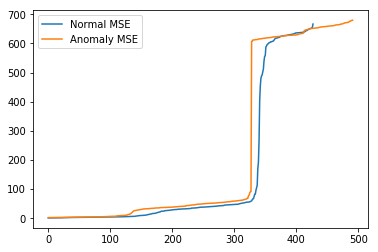

In [38]:
normaly = sorted(scores[('error', 'norm')])
anomaly = sorted(scores[('error', 'fail')])
plt.plot(normaly, label='Normal MSE')
plt.plot(anomaly, label='Anomaly MSE')
plt.legend()

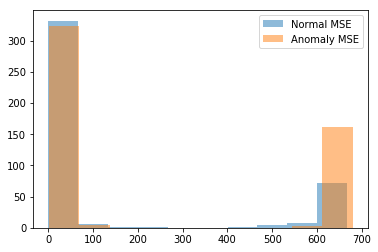

In [39]:
plt.hist(normaly, label='Normal MSE', alpha=0.5)
plt.hist(anomaly, label='Anomaly MSE', alpha=0.5)
plt.legend()

In [40]:
normalx = np.random.rand(len(normaly))
anomalx = np.random.rand(len(anomaly))

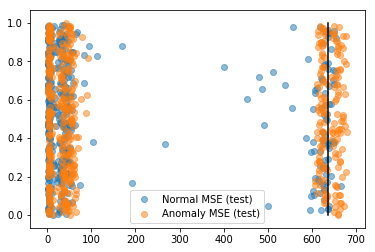

In [41]:
plt.scatter(normaly, normalx, label='Normal MSE (test)', alpha=0.5)
plt.scatter(anomaly, anomalx, label='Anomaly MSE (test)', alpha=0.5)
plt.plot([threshold, threshold], [0, 1], 'k-')
plt.legend()

Try fitting a normal distribution to the validation MSE to define a threshold.

In [42]:
val_scores = score(val_dl, model, criterion)

100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


In [43]:
val_scores.keys()

dict_keys([('loss', 'norm'), ('KL', 'norm'), ('error', 'norm')])

[0.8436821699142456, 0.8714967370033264, 0.8995327353477478, 0.9233752489089966, 0.9372830390930176]
mean=142.66, stdev=234.86


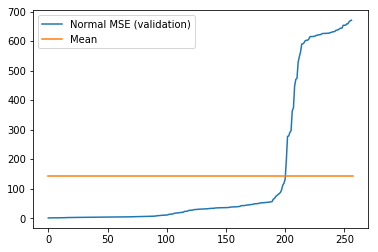

In [44]:
val_norm = sorted(val_scores[('error', 'norm')])
print(val_norm[:5])
mean = np.mean(val_norm)
std = np.std(val_norm)
print('mean={:.2f}, stdev={:.2f}'.format(mean, std))
plt.plot(val_norm, label= 'Normal MSE (validation)')
plt.plot([0, len(val_norm)], [mean, mean], label='Mean')
plt.legend()

Implement PCA to visualize the latent space.

In [45]:
latents, targets = compute_latent(test_dl, model)

100%|██████████| 920/920 [00:05<00:00, 154.46it/s]


In [46]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=2)

In [48]:
lat_pca = pca.fit_transform(latents)

In [49]:
lat_pca.shape

(920, 2)

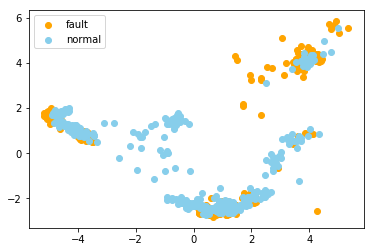

In [50]:
fail_mask = targets == 0
norm_mask = targets == 1
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [51]:
pca.explained_variance_ratio_

array([0.39460766, 0.2605066 ], dtype=float32)

Cluster the latent space into kmeans clusters.

In [52]:
from sklearn.cluster import KMeans

In [53]:
kmeans = KMeans(3)

In [54]:
lat_k = kmeans.fit_transform(latents)

In [55]:
lat_k.shape

(920, 3)

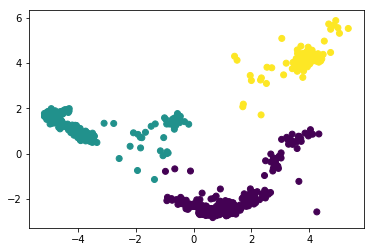

In [56]:
plt.scatter(lat_pca[:, 0], lat_pca[:, 1], c=kmeans.labels_)

Try adding the error terms to the latent features.

In [57]:
latents, kl, error, targets = compute_latent_and_loss(test_dl, model, criterion)

100%|██████████| 920/920 [00:06<00:00, 151.16it/s]


In [58]:
print(latents.shape, kl.shape, error.shape, targets.shape)

(920, 50) (920,) (920,) (920,)


In [59]:
features = np.hstack([latents, kl[:, None], error[:, None]])
features.shape

(920, 52)

In [60]:
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(features)
lat_pca.shape

(920, 2)

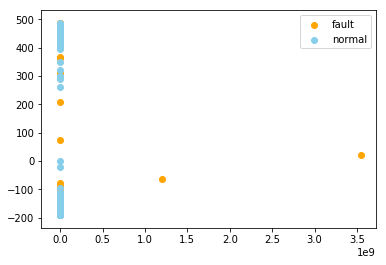

In [61]:
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [62]:
pca.explained_variance_ratio_

array([1.00000000e+00, 4.80463394e-12])

Compare the pca plots for validation and training sets.

100%|██████████| 33/33 [00:05<00:00,  6.09it/s]


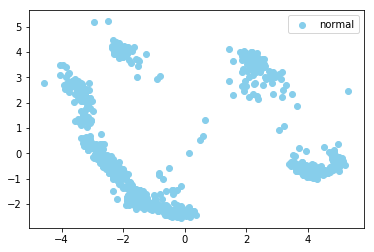

In [63]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

100%|██████████| 9/9 [00:01<00:00,  6.02it/s]


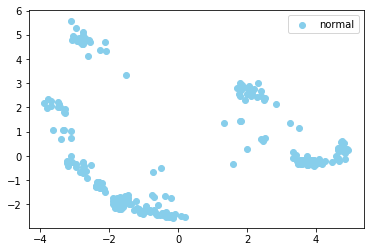

In [64]:
latents, targets = compute_latent(val_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

Combine the validation plot with the test plot to understand global structure.

In [65]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
train_pca = pca.fit_transform(latents)

100%|██████████| 33/33 [00:05<00:00,  6.07it/s]


In [66]:
latents, targets = compute_latent(val_dl, model)
val_pca = pca.transform(latents)

100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


In [67]:
latents, targets = compute_latent(test_dl, model)
test_pca = pca.transform(latents)
fail_mask = targets == 0
norm_mask = targets == 1

100%|██████████| 920/920 [00:05<00:00, 153.69it/s]


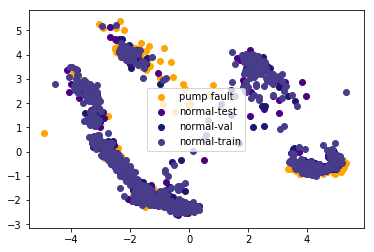

In [68]:
plt.scatter(test_pca[fail_mask, 0], test_pca[fail_mask, 1],
            c='orange', label=desc + ' fault')
plt.scatter(test_pca[norm_mask, 0], test_pca[norm_mask, 1],
            c='indigo', label='normal-test')
plt.scatter(val_pca[:, 0], val_pca[:, 1],
            c='midnightblue', label='normal-val')
plt.scatter(train_pca[:, 0], train_pca[:, 1],
            c='darkslateblue', label='normal-train')
plt.legend()